In [1]:
import time
from multiprocessing import Pool

from IPython.display import display
import sympy
sympy.init_printing()

from pylab import *
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from itertools import cycle
lstyle = cycle(('-', '--', ':', '-.',\
    (0, (1, 10)), (0, (5, 10)),\
    (0, (5, 5)), (0, (3, 10, 1, 10)),\
    (0, (3, 5, 1, 5)), \
    (0, (3, 5, 1, 5, 1, 5))))
color = cycle(('#1f77b4', '#ff7f0e', '#2ca02c',\
    '#d62728', '#9467bd', '#8c564b', '#e377c2',\
    '#7f7f7f', '#bcbd22', '#17becf'))


from scipy.sparse import *
from scipy.sparse.linalg import spsolve

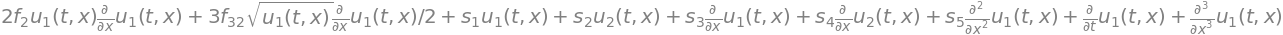

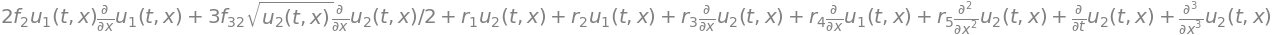

In [2]:
t, x, f2, f32 = sympy.symbols('t, x, f2, f32', real=True)
s1, s2, s3, s4, s5 = sympy.symbols('s1, s2, s3, s4, s5', real=True)
r1, r2, r3, r4, r5 = sympy.symbols('r1, r2, r3, r4, r5', real=True)
u1, u2 = sympy.symbols('u1', cls=sympy.Function)(t, x),\
         sympy.symbols('u2', cls=sympy.Function)(t, x)
eq1 = u1.diff(t) + (f2*u1**2 + f32*sympy.sqrt(u1)*u1).diff(x) + u1.diff(x,3) +\
   s1*u1 + s2*u2 + s3*u1.diff(x) + s4*u2.diff(x) + s5*u1.diff(x, 2)
display(eq1)
eq2 = u2.diff(t) + (f2*u1**2 + f32*sympy.sqrt(u2)*u2).diff(x) + u2.diff(x,3) +\
   r2*u1 + r1*u2 + r4*u1.diff(x) + r3*u2.diff(x) + r5*u2.diff(x, 2)
eq2

In [3]:
k, d = sympy.symbols('k, d', real=True)

\begin{equation}
\begin{aligned}
  v^2_{k+1} &= v^2_{k+1} - v^2_{k} + v^2_{k} = (v_{k+1} - v_{k})(v_{k+1} + v_{k}) + v^2_{k}
\approx v_{k+1}\cdot 2v_{k} - v_{k}^2 , \\
v^{3/2}_{k+1} &= v^{3/2}_{k+1} - v^{3/2}_{k} + v^{3/2}_{k} = 
(v^{1/2}_{k+1} - v^{1/2}_{k})(v_{k+1} +v_{k+1}^{1/2}v_{k}^{1/2} + v_{k}) + v^{3/2}_{k}  = {} \\ {} &=
(v_{k+1} - v_{k})\frac{v_{k+1} +v_{k+1}^{1/2}v_{k}^{1/2} + v_{k}}{v^{1/2}_{k+1} + v^{1/2}_{k}}  + v^{3/2}_{k}
\approx v_{k+1}\cdot \frac{3}{2}v_{k}^{1/2} - \frac{1}{2}v_{k}^{3/2} .
\end{aligned}
\end{equation}

Система уравнений
\begin{equation}
  \begin{split}
    \varphi_t^{(1)}&+\left(f_2{\varphi^{(1)}}^2 + f_{32}{\varphi^{(1)}}^{3/2}\right)_\eta+\varphi_{\eta\eta\eta}^{(1)} 
+ s_1\varphi^{(1)}
+ s_2\varphi^{(2)}
+ s_3\varphi^{(1)}_\eta
+ s_4\varphi^{(2)}_\eta
+ s_3 \varphi^{(1)}_{\eta\eta}
=0,\\
    \varphi_t^{(2)}&+\left(f_2{\varphi^{(2)}}^2 + f_{32}{\varphi^{(2)}}^{3/2}\right)_\eta+\varphi_{\eta\eta\eta}^{(2)}
+ r_1\varphi^{(2)}
+ r_2\varphi^{(1)}
+ r_3\varphi^{(2)}_\eta
+ r_4\varphi^{(1)}_\eta
+ r_3 \varphi^{(2)}_{\eta\eta} =0
  \end{split}
\end{equation} 

In [4]:
def solve(u10, u20, dx, t1, n):
    """
    u10, u20 - начальное приближение
    dx - шаг по x
    t1 - конечное время
    n - число шагов по времени
    """
    N = len(u10)
    assert N == len(u20)
    assert 25 <= N
    
    dt = 0.5*dx
    
    # вспомогательные массивы для задания разреженной матрицы
    row = empty((2, N, 8), dtype=int32)
    col = zeros((2, N, 8), dtype=int32)
    data = zeros((2, N, 8), dtype=float64)

    # столбец свободных членов
    b = zeros((2, N), dtype=float64)

    # за нормировку строк матрицы взято dt/dx = O(1)
    for i in range(N):
        row[0, i] = i
        row[1, i] = N+i
    for i in range(2, N-2):
        col[0, i] = i-2, i-1, i, i+1, i+2, N+i-1, N+i, N+i+1
        col[1, i] = N+i-2, N+i-1, N+i, N+i+1, N+i+2, i-1, i, i+1

    # граничные условия в точке x[0]
    col[0, 0, :3] = 0, 2, 3
    col[1, 0, :3] = N, N+2, N+3
    data[:, 0, :3] = -5., 9., -4.
    # граничные условия в точке x[1]
    col[0, 1, :3] = 1, 2, 3
    col[1, 1, :3] = N+1, N+2, N+3
    data[:, 1, :3] = -5., 8., -3.
    # граничные условия в точке x[-2]
    col[0, -2, :3] = N-2, N-3, N-4
    col[1, -2, :3] = 2*N-2, 2*N-3, 2*N-4
    data[:, -2, :3] = -5., 8., -3.
    # граничные условия в точке x[-1]
    col[0, -1, :3] = N-1, N-3, N-4
    col[1, -1, :3] = 2*N-1, 2*N-3, 2*N-4
    data[:, -1, :3] = -5., 9., -4.
    b[:, -1] = 0.

    # задание неизменных элементов матрицы
    # (ответственны за линейные члены)
    data[0, 2:-2, 0] = -dt/(4.*dx**3)
    data[0, 2:-2, 2] = 1. + dt/2.*s1 - 2.*s5*dt/dx**2
    data[0, 2:-2, 4] = dt/(4.*dx**3)
    data[0, 2:-2, 5:] = -dt*s4/(4.*dx), dt/2.*s2, dt*s4/(4.*dx)

    data[1, 2:-2, 0] = -dt/(4.*dx**3)
    data[1, 2:-2, 2] = 1. + dt/2.*r1 - 2.*r5*dt/dx**2
    data[1, 2:-2, 4] = dt/(4.*dx**3)
    data[1, 2:-2, 5:] = -dt*r4/(4.*dx), dt/2.*r2, dt*r4/(4.*dx)
    
    def sqr(f):
#         return sqrt((f + absolute(f))/2.)
#         return sqrt(absolute(f))*sign(f)
        return sqrt(absolute(f))

    # начальное условие, накопление промежуточных решений
    # с шагом по времени k*dt и в количестве n
    u, sol1, sol2, k = concatenate((u10, u20)), [(0.0, u10)], [(0.0, u20)], int(t1/dt)//n
    for i in range(1, int(t1/dt)+1):
        # начало простой итерации для построения v решения для следующего временного слоя
        v, f, j = copy(u), True, 0
        while f:
            # задание переменных элементов матрицы
            # (ответственны за нелинейные члены)
            data[0, 2:-2, 1] = dt/dx*(-f2*v[1:N-3]/2. -  f32*sqr(v[1:N-3])*(3./8.)\
                                    + 2./(4.*dx**2) - s3/4. + s5/dx)
            data[0, 2:-2, 3] = dt/dx*( f2*v[3:N-1]/2. +  f32*sqr(v[3:N-1])*(3./8.)\
                                    - 2./(4.*dx**2) + s3/4. + s5/dx)
            data[1, 2:-2, 1] = dt/dx*(-f2*v[N+1:-3]/2. - f32*sqr(v[N+1:-3])*(3./8.)\
                                    + 2./(4.*dx**2) - r3/4. + r5/dx)
            data[1, 2:-2, 3] = dt/dx*( f2*v[N+3:-1]/2. + f32*sqr(v[N+3:-1])*(3./8.)\
                                    - 2./(4.*dx**2) + r3/4. + r5/dx)
            
            # вычисление правой части
            b[0, 2:-2] = u[2:N-2] + dt/dx*(\
                + f2*(v[3:N-1]**2 - v[1:N-3]**2)/4.\
                - f2*(u[3:N-1]**2 - u[1:N-3]**2)/4.\
                + f32*(v[3:N-1]*sqrt(absolute(v[3:N-1])) - v[1:N-3]*sqrt(absolute(v[1:N-3])))/8.\
                - f32*(u[3:N-1]*sqr(u[3:N-1]) - u[1:N-3]*sqr(u[1:N-3]))/4.\
                - (u[4:N] - 2.*u[3:N-1] + 2.*u[1:N-3] - u[:N-4])/(4.*dx**2)
                - s3*(u[3:N-1] - u[1:N-3])/4.\
                - s4*(u[N+3:-1] - u[N+1:-3])/4.\
                - s5*(u[N+3:-1] - 2.*u[N+2:-2] + u[N+1:-3])/4.)\
                - (u[2:N-2]*s1 + u[N+2:-2]*s2)*(dt/2.)
            b[1, 2:-2] = u[N+2:-2] + dt/dx*(\
                + f2*(v[N+3:-1]**2 - v[N+1:-3]**2)/4.\
                - f2*(u[N+3:-1]**2 - u[N+1:-3]**2)/4.\
                + f32*(v[N+3:-1]*sqr(v[N+3:-1]) - v[N+1:-3]*sqr(v[N+1:-3]))/8.\
                - f32*(u[N+3:-1]*sqr(u[N+3:-1]) - u[N+1:-3]*sqr(u[N+1:-3]))/4.\
                - (u[N+4:] - 2.*u[N+3:-1] + 2.*u[N+1:-3] - u[N:-4])/(4.*dx**2)
                - r3*(u[N+3:-1] - u[N+1:-3])/4. \
                - r4*(u[3:N-1] - u[1:N-3])/4.\
                - r5*(u[N+3:-1] - 2.*u[N+2:-2] + u[N+1:-3])/4.)\
                - (u[N+2:-2]*r1 + u[2:N-2]*r2)*(dt/2.)
                
            # решение разреженной системы линейных уравнений
            v1 = spsolve(csr_matrix((data.reshape(2*N*8),\
                (row.reshape(2*N*8), col.reshape(2*N*8))),\
                shape=(2*N, 2*N)), b.reshape(2*N))
            # условие выхода из простой итерации
            f = norm(v - v1) > 1.e-9
            v = v1
            j += 1
        u = v
        # накопление промежуточных решений
        if i % k == 0 : 
            print(j, end=" ") # вывод числа итераций
            sol1.append((i*dt, u[:N]))
            sol2.append((i*dt, u[N:]))
    return sol1, sol2

In [5]:
def draw(sol1, sol2, name=""):
    figure(figsize=(15.0, 4.0))
    splt1 = subplot(1, 2, 1)
    ylabel(r'$\varphi^{(1)}$', {'fontsize': 18})
    xlabel(r'$\eta$', {'fontsize': 18})
    setp(splt1.get_xticklabels(), visible=True)
    grid(True)
    splt2 = subplot(1, 2, 2, sharex=splt1, sharey=splt1)
    ylabel(r'$\varphi^{(2)}$', {'fontsize': 18})
    xlabel(r'$\eta$', {'fontsize': 18})
    grid(True)
    for t, u in sol1: 
        splt1.plot(x, u, label="$t=%.2f$" % t)
    for t, u in sol2: 
        splt2.plot(x, u, label="$t=%.2f$" % t)
    splt1.legend(loc='best', fancybox=True)
    splt2.legend(loc='best', fancybox=True)
    y0, y1 = ylim()
    ylim(y0 - (y1-y0)*.05, y1 + (y1-y0)*.05)
    #print(ylim())
    if name: savefig(name)
    else: show()
    close()

def draw3D(sol1, sol2, name=""):
    fig = figure(figsize=(10, 8))
    ax1 = fig.add_subplot(2, 1, 1, projection='3d')
    setp(ax1.get_xticklabels(), visible=True)
    ax1.set_xlabel(r'$\eta$', {'fontsize': 14})
    ax1.set_ylabel(r'время $t$', {'fontsize': 14})
    ax1.set_zlabel(r'$\phi^{(1)}$', {'fontsize': 14})
    ax2 = fig.add_subplot(2, 1, 2, projection='3d', sharex=ax1, sharey=ax1)
    ax2.set_xlabel(r'$\eta$', {'fontsize': 14})
    ax2.set_ylabel(r'время $t$', {'fontsize': 14})
    ax2.set_zlabel(r'$\phi^{(2)}$', {'fontsize': 14})
    for t, u in sol1:
          ax1.plot(x, t*ones_like(x), u, color='k')
    for t, u in sol2:
          ax2.plot(x, t*ones_like(x), u, color='k')
    if name: savefig(name)
    else: show()
    close()

In [6]:
def ex1(x, t, k):
    return 25*k**4*cosh(k*x - 16*k**3*t)**-4
def ex2(x, t, k):
    return 25*k**4/4*(1 + cosh(k*x - 4*k**3*t))**-2
def ex3(x, t, k):
    return 25*k**4/4*(1 + sqrt(1 + 25/8*k**2)*cosh(k*x - 4*k**3*t))**-2

In [7]:
# размер расчетной области 0 <= x <= L и число точек на ней
L, N = 150., 301

In [8]:
k = 0.2
f2, f32 = 3., 4.
s1, s2, s3, s4, s5 = 0., 0., 0.1, 0., 0.
r1, r2, r3, r4, r5 = 0., 0., 0.1, 0., 0.
x = array(linspace(-L*.3, L*.7, N), dtype=float64)
sol1, sol2 = solve(ex3(x, 0., k), ex3(x, 0., k), x[1] - x[0], 145., 4)

3 3 3 3 

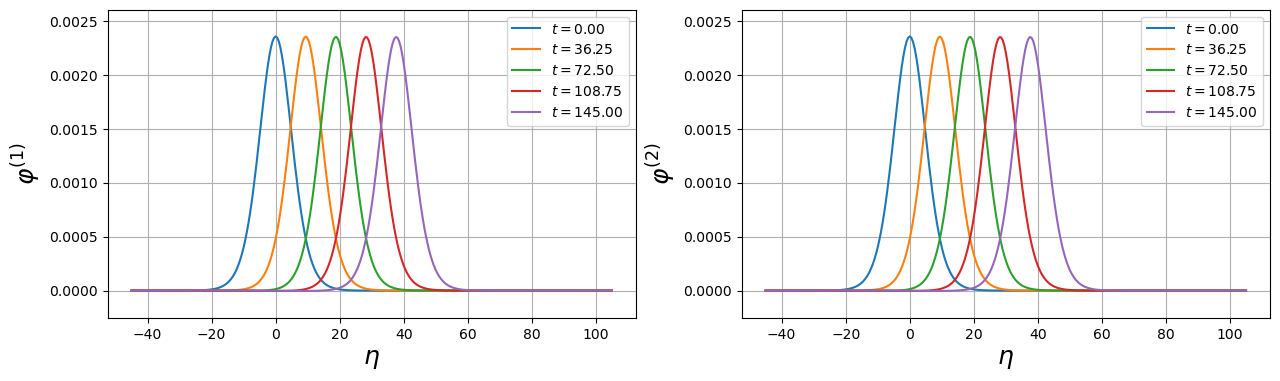

In [9]:
draw(sol1, sol2)
# draw(sol1, sol2, "fig2_2_1.png")
# draw(sol1, sol2, "fig2_2_1.pdf")

<img src="./123.png"/>
1а) сигма1 равна 1 (единица), сигма2,3,4.равны 0(нулю):нет жидкости во внутренней оболочке 

1б) сигмы2,3,4,1 равны нулю кроме предыдущего случая, нет инерции между оболочками

1в) сигмы2,3, равны 0(нулю) сигмы1,4 равны1(единице)-нет жидкости внутри

1г) сигмы2,3, равны 0(нулю) сигмы1,4,5 равны1(единице)-нет жидкости внутри

2а) Сигма2,4 равны 0( нулю) сигмы1,3 равны1(единице)нет трения внутри и нет окруж. среды

2б) сигмы1,2,3,равны 1(единице) сигма4 равна0(нулю) нет окружающей среды

2в) все сигмы равны 1(единице)   все факторы есть

2г) все сигмы равны 1(единице) + сигмы5=1   все факторы есть

In [10]:
k = 0.2
f2, f32 = 3., 4.
# 1а) сигма1 равна 1 (единица), сигма2,3,4.равны 0(нулю):нет жидкости во внутренней оболочке 
sig1, sig2, sig3, sig4, sig5 = 0.2, 0., 0., 0., 0.
s1, s2, s3, s4, s5 = 1. + sig5, -1., -sig1 + sig4, sig1, 0.
r1, r2, r3, r4, r5 = 1. + sig2 + sig5, -1., -sig1 - sig3, sig1, 0.
x = array(linspace(-L*.3, L*.7, N), dtype=float64)
sol1, sol2 = solve(ex3(x, 0., k), ex3(x, 0., k), x[1] - x[0], 345., 4)

3 3 3 3 

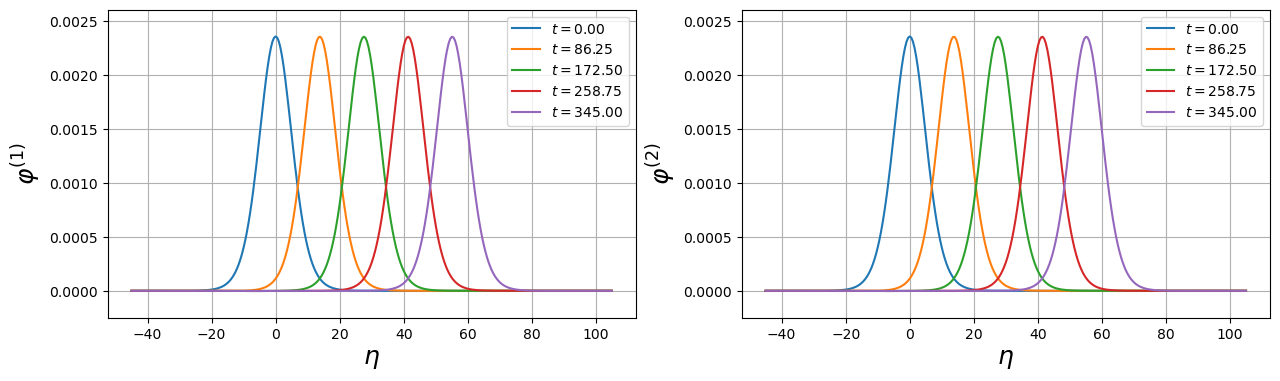

In [11]:
draw(sol1, sol2)
draw(sol1, sol2, "./KDV2-Schamel1.png")

In [12]:
k = 0.2
f2, f32 = 3., 4.
# 1а) сигма1 равна 1 (единица), сигма2,3,4.равны 0(нулю):нет жидкости во внутренней оболочке 
sig1, sig2, sig3, sig4, sig5 = 0.2, 0., 0., 0., 0.
s1, s2, s3, s4, s5 = 1. + sig5, -1., -sig1 + sig4, sig1, 0.
r1, r2, r3, r4, r5 = 1. + sig2 + sig5, -1., -sig1 - sig3, sig1, 0.
x = array(linspace(-L*.5, L*.5, N), dtype=float64)
sol1, sol2 = solve(ex3(x, 0., k), 0.*ex3(x, 0., k), x[1] - x[0], 345., 4)

2 2 2 2 

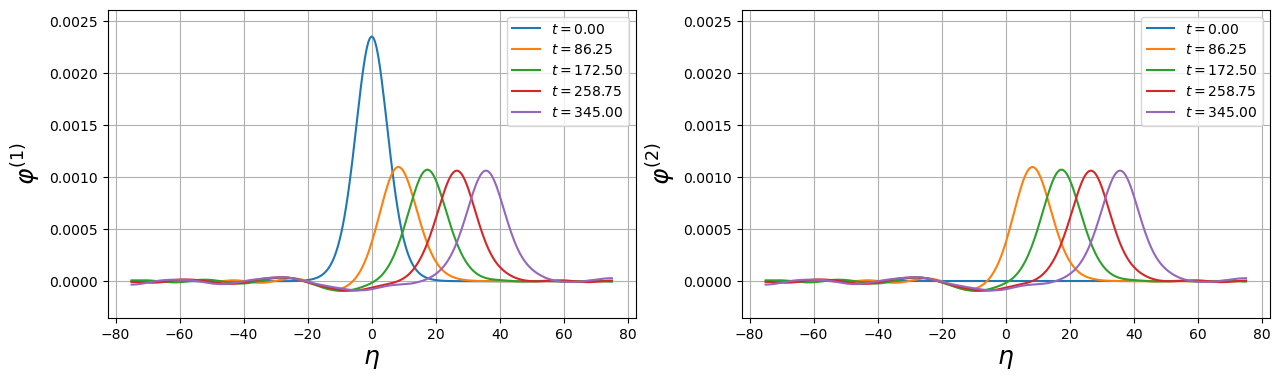

In [13]:
draw(sol1, sol2)
draw(sol1, sol2, "./KDV2-Schamel2.png")

In [14]:
k1, k2 = 0.225, 0.2
f2, f32 = 3., 4.
# 1а) сигма1 равна 1 (единица), сигма2,3,4.равны 0(нулю):нет жидкости во внутренней оболочке
# Второе решение к1=0,225=18\80 - больший а к2=0,2=16\80 - меньший солитон
sig1, sig2, sig3, sig4, sig5 = 0.2, 0., 0., 0., 0.
s1, s2, s3, s4, s5 = 1. + sig5, -1., -sig1 + sig4, sig1, 0.
r1, r2, r3, r4, r5 = 1. + sig2 + sig5, -1., -sig1 - sig3, sig1, 0.
x = array(linspace(-L*0.6, L*2.4, 3*N), dtype=float64)
sol1, sol2 = solve(ex3(x + L*0.3, 0., k1) + ex3(x, 0., k2),\
                   ex3(x + L*0.3, 0., k1) + ex3(x, 0., k2), x[1] - x[0], 1305., 4)

3 3 3 3 

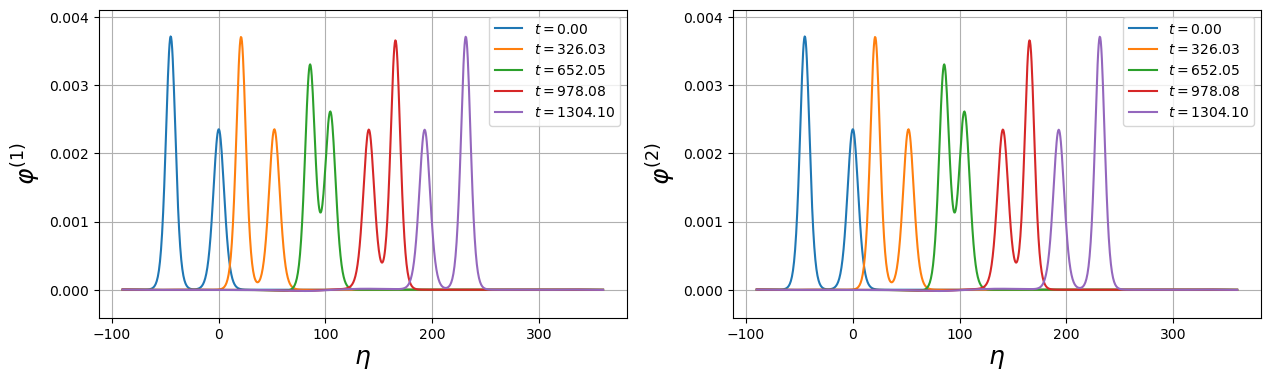

In [15]:
draw(sol1, sol2)
draw(sol1, sol2, "./KDV2-Schamel3.png")

In [16]:
k = 0.2
f2, f32 = 3., 4.
# 1б) сигмы2,3,4,1 равны нулю кроме предыдущего случая, нет инерции между оболочками
sig1, sig2, sig3, sig4, sig5 = 0., 0., 0., 0., 0.
s1, s2, s3, s4, s5 = 1. + sig5, -1., -sig1 + sig4, sig1, 0.
r1, r2, r3, r4, r5 = 1. + sig2 + sig5, -1., -sig1 - sig3, sig1, 0.
x = array(linspace(-L*.3, L*.7, N), dtype=float64)
sol1, sol2 = solve(ex3(x, 0., k), ex3(x, 0., k), x[1] - x[0], 145., 4)

3 3 3 3 

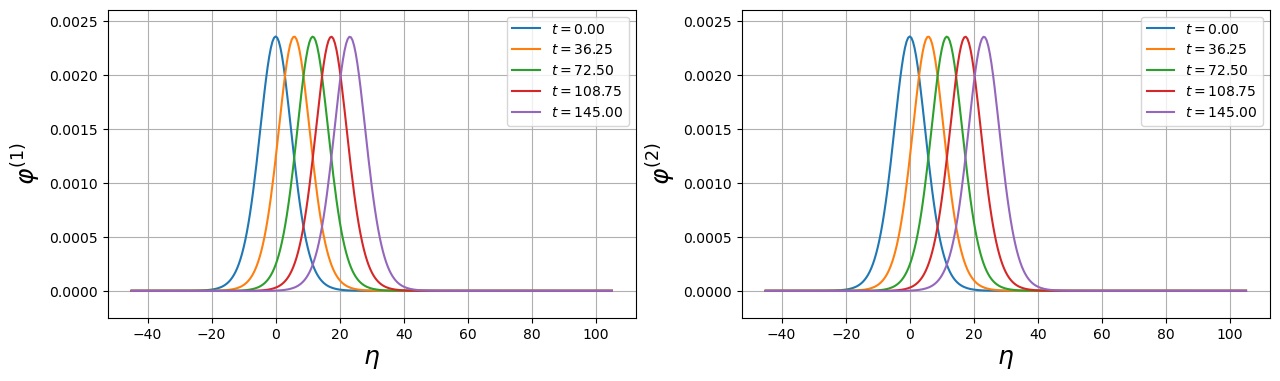

In [17]:
draw(sol1, sol2)
draw(sol1, sol2, "./KDV2-Schamel4.png")

In [18]:
k = 0.2
f2, f32 = 3., 4.
# 1б) сигмы2,3,4,1 равны нулю кроме предыдущего случая, нет инерции между оболочками
sig1, sig2, sig3, sig4, sig5 = 0., 0., 0., 0., 0.
s1, s2, s3, s4, s5 = 1. + sig5, -1., -sig1 + sig4, sig1, 0.
r1, r2, r3, r4, r5 = 1. + sig2 + sig5, -1., -sig1 - sig3, sig1, 0.
x = array(linspace(-L*.5, L*.5, N), dtype=float64)
sol1, sol2 = solve(ex3(x, 0., k), 0.*ex3(x, 0., k), x[1] - x[0], 145., 4)

2 2 2 2 

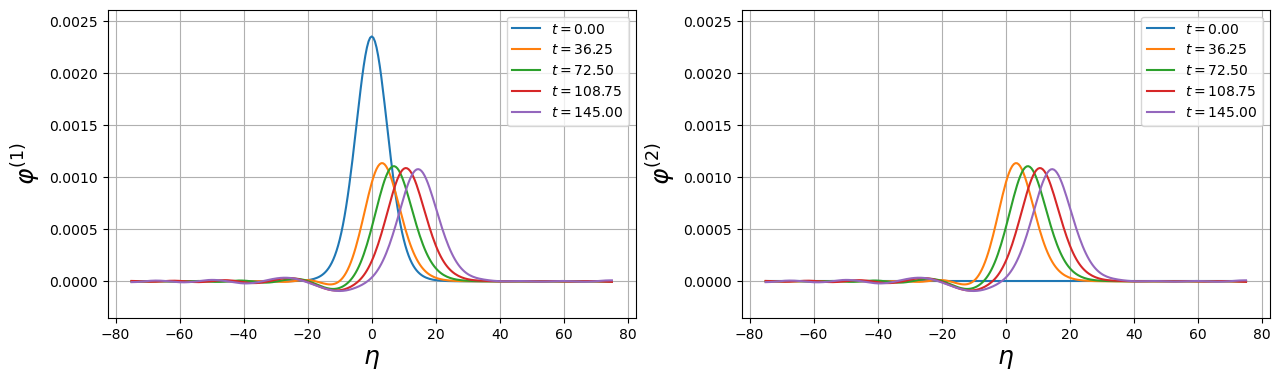

In [19]:
draw(sol1, sol2)
draw(sol1, sol2, "./KDV2-Schamel5.png")

In [20]:
k = 0.2
f2, f32 = 3., 4.
# 1в) сигмы2,3, равны 0(нулю) сигмы1,4 равны1(единице)-нет жидкости внутри
sig1, sig2, sig3, sig4, sig5 = 0.2, 0., 0., 0.2, 0.
s1, s2, s3, s4, s5 = 1. + sig5, -1., -sig1 + sig4, sig1, 0.
r1, r2, r3, r4, r5 = 1. + sig2 + sig5, -1., -sig1 - sig3, sig1, 0.
x = array(linspace(-L*.3, L*0.7, N), dtype=float64)
sol1, sol2 = solve(ex3(x, 0., k), ex3(x, 0., k), x[1] - x[0], 105., 4)

3 3 3 3 

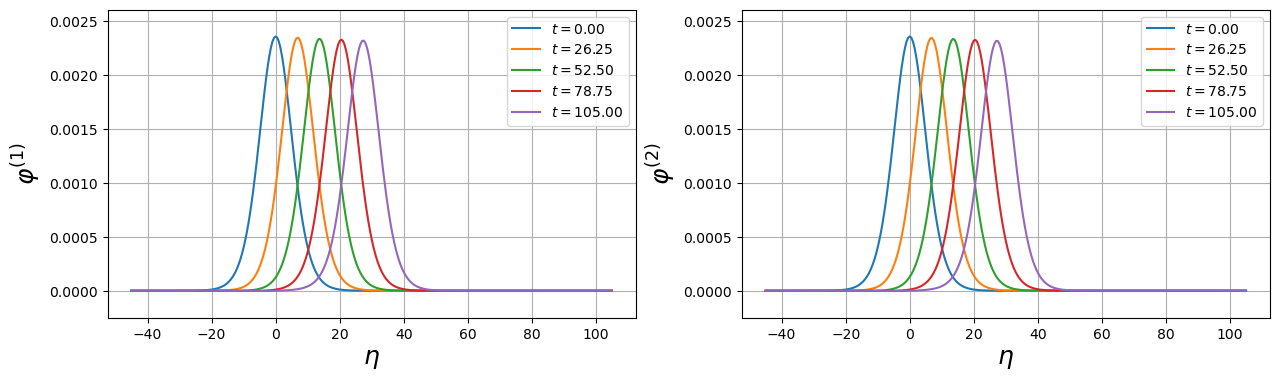

In [21]:
draw(sol1, sol2)
draw(sol1, sol2, "./KDV2-Schamel6.png")

In [22]:
k = 0.2
f2, f32 = 3., 4.
# 1в) сигмы2,3, равны 0(нулю) сигмы1,4 равны1(единице)-нет жидкости внутри
sig1, sig2, sig3, sig4, sig5 = 0.2, 0., 0., 0.2, 0.
s1, s2, s3, s4, s5 = 1. + sig5, -1., -sig1 + sig4, sig1, 0.
r1, r2, r3, r4, r5 = 1. + sig2 + sig5, -1., -sig1 - sig3, sig1, 0.
x = array(linspace(-L*.3, L*0.7, N), dtype=float64)
sol1, sol2 = solve(ex3(x, 0., k), 0.*ex3(x, 0., k), x[1] - x[0], 105., 4)

2 2 2 2 

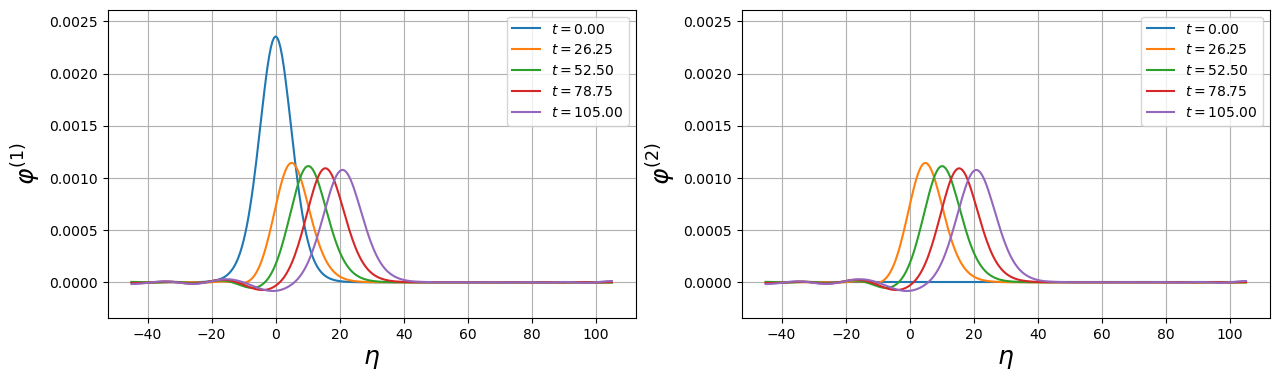

In [23]:
draw(sol1, sol2)
draw(sol1, sol2, "./KDV2-Schamel7.png")

In [24]:
k = 0.2
f2, f32 = 3., 4.
# 1г) сигмы2,3, равны 0(нулю) сигмы1,4,5 равны1(единице)-нет жидкости внутри
sig1, sig2, sig3, sig4, sig5 = 0.2, 0., 0., 0.2, 0.2
s1, s2, s3, s4, s5 = 1. + sig5, -1., -sig1 + sig4, sig1, 0.
r1, r2, r3, r4, r5 = 1. + sig2 + sig5, -1., -sig1 - sig3, sig1, 0.
x = array(linspace(-L*.3, L*0.7, N), dtype=float64)
sol1, sol2 = solve(ex3(x, 0., k), ex3(x, 0., k), x[1] - x[0], 15., 4)

3 3 3 2 

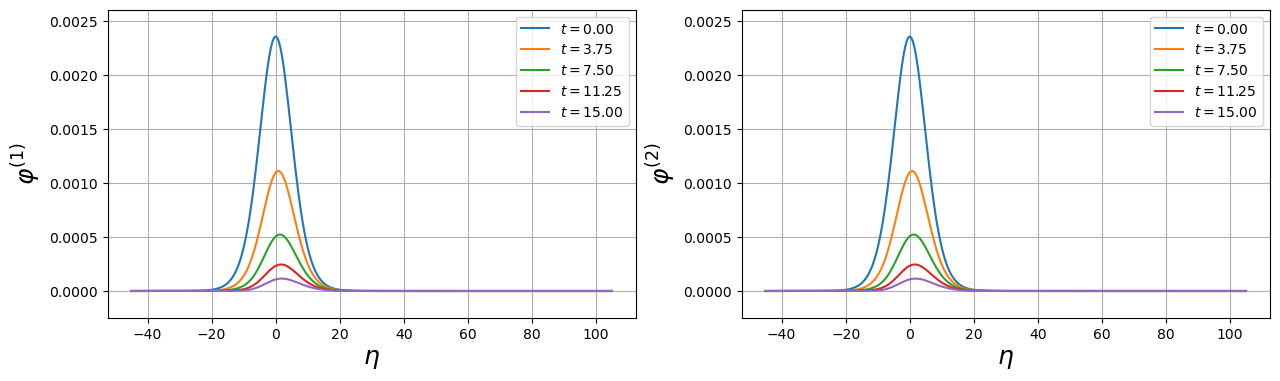

In [25]:
draw(sol1, sol2)
draw(sol1, sol2, "./KDV2-Schamel8.png")

In [26]:
k = 0.2
f2, f32 = 3., 4.
# 1г) сигмы2,3, равны 0(нулю) сигмы1,4,5 равны1(единице)-нет жидкости внутри
sig1, sig2, sig3, sig4, sig5 = 0.2, 0., 0., 0.2, 0.2
s1, s2, s3, s4, s5 = 1. + sig5, -1., -sig1 + sig4, sig1, 0.
r1, r2, r3, r4, r5 = 1. + sig2 + sig5, -1., -sig1 - sig3, sig1, 0.
x = array(linspace(-L*.3, L*0.7, N), dtype=float64)
sol1, sol2 = solve(ex3(x, 0., k), 0.*ex3(x, 0., k), x[1] - x[0], 15., 4)

3 3 2 2 

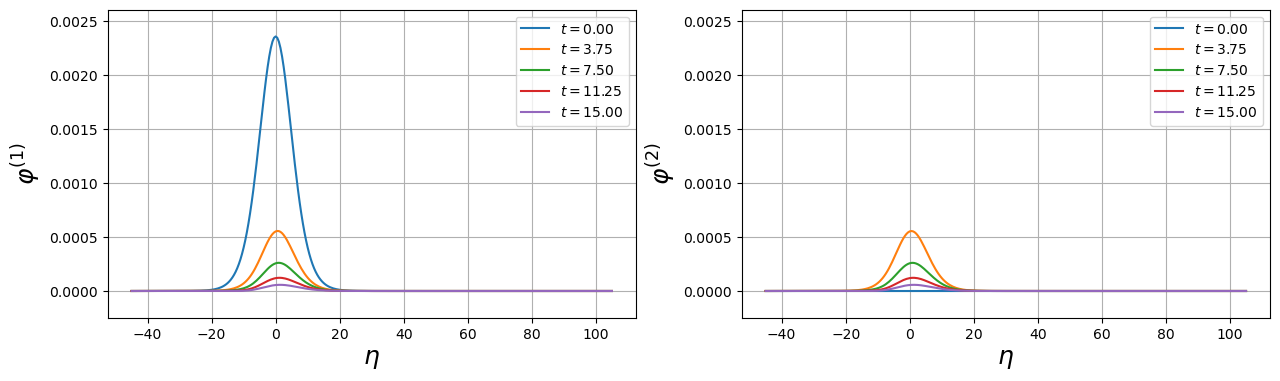

In [27]:
draw(sol1, sol2)
draw(sol1, sol2, "./KDV2-Schamel9.png")

In [28]:
k = 0.2
f2, f32 = 3., 4.
# 2а) Сигма2,4 равны 0( нулю) сигмы1,3 равны1(единице)нет трения внутри и нет окруж. среды
sig1, sig2, sig3, sig4, sig5 = 0.2, 0., 0.4, 0., 0.
s1, s2, s3, s4, s5 = 1. + sig5, -1., -sig1 + sig4, sig1, 0.
r1, r2, r3, r4, r5 = 1. + sig2 + sig5, -1., -sig1 - sig3, sig1, 0.
x = array(linspace(-L*.7, L*.3, N), dtype=float64)
sol1, sol2 = solve(ex3(x, 0., k), ex3(x, 0., k), x[1] - x[0], 505., 4)

2 2 2 2 

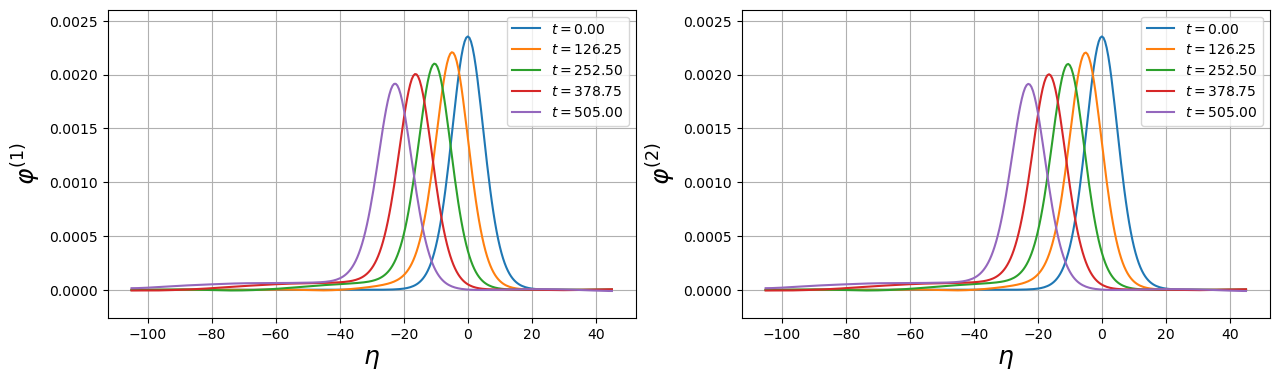

In [29]:
draw(sol1, sol2)
draw(sol1, sol2, "./KDV2-Schamel10.png")

In [30]:
k = 0.2
f32 = 4.
# 2а) Сигма2,4 равны 0( нулю) сигмы1,3 равны1(единице)нет трения внутри и нет окруж. среды
sig1, sig2, sig3, sig4, sig5 = 0.2, 0., 0.4, 0., 0.
s1, s2, s3, s4, s5 = 1. + sig5, -1., -sig1 + sig4, sig1, 0.
r1, r2, r3, r4, r5 = 1. + sig2 + sig5, -1., -sig1 - sig3, sig1, 0.
x = array(linspace(-L*.7, L*.3, N), dtype=float64)
sol1, sol2 = solve(ex3(x, 0., k), 0.*ex3(x, 0., k), x[1] - x[0], 505., 4)

2 2 2 2 

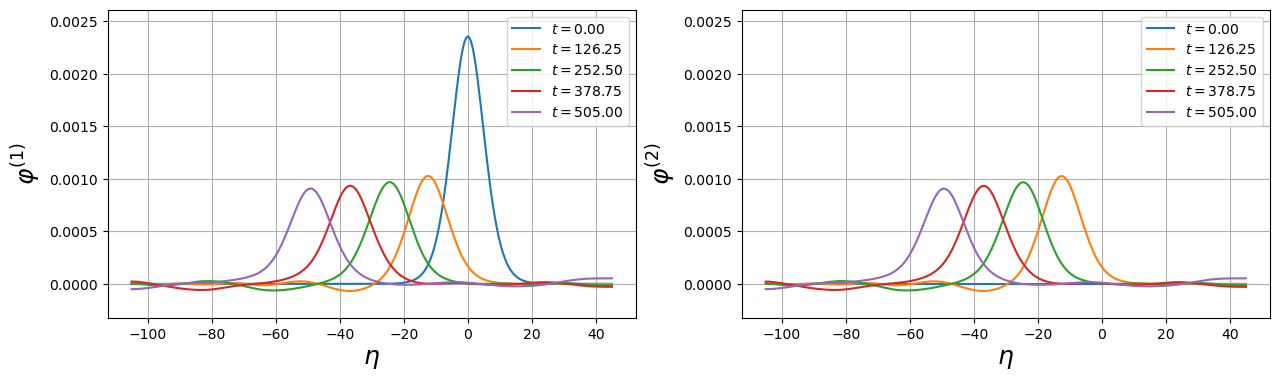

In [31]:
draw(sol1, sol2)
draw(sol1, sol2, "./KDV2-Schamel11.png")

In [32]:
k = 0.2
f2, f32 = 3., 4.
# 2б) сигмы1,2,3,равны 1(единице) сигма4 равна0(нулю) нет окружающей среды
sig1, sig2, sig3, sig4, sig5 = 0.2, 0.2, 0.4, 0., 0.
s1, s2, s3, s4, s5 = 1. + sig5, -1., -sig1 + sig4, sig1, 0.
r1, r2, r3, r4, r5 = 1. + sig2 + sig5, -1., -sig1 - sig3, sig1, 0.
x = array(linspace(-L*.5, L*.5, N), dtype=float64)
sol1, sol2 = solve(ex3(x, 0., k), ex3(x, 0., k), x[1] - x[0], 45., 4)

3 2 2 2 

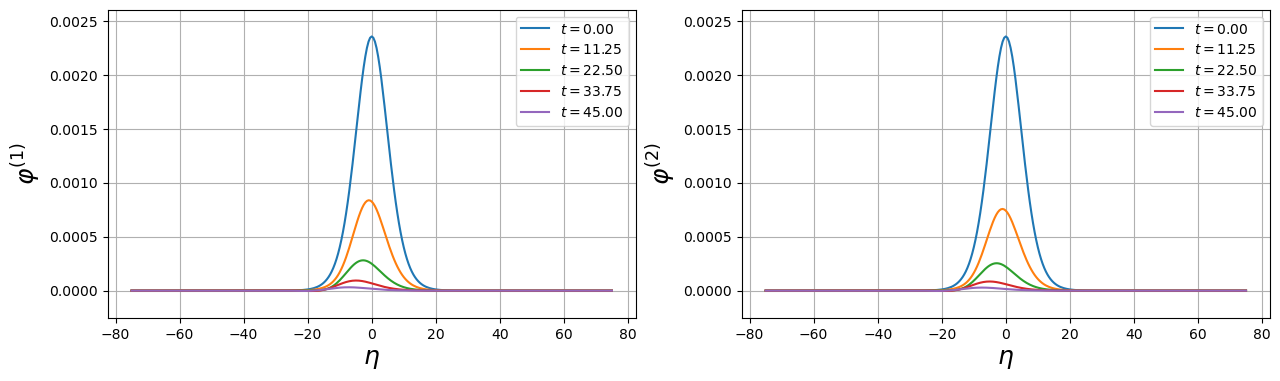

In [33]:
draw(sol1, sol2)
draw(sol1, sol2, "./KDV2-Schamel12.png")

In [34]:
k = 0.2
f2, f32 = 3., 4.
# 2б) сигмы1,2,3,равны 1(единице) сигма4 равна0(нулю) нет окружающей среды
sig1, sig2, sig3, sig4, sig5 = 0.2, 0.2, 0.4, 0., 0.
s1, s2, s3, s4, s5 = 1. + sig5, -1., -sig1 + sig4, sig1, 0.
r1, r2, r3, r4, r5 = 1. + sig2 + sig5, -1., -sig1 - sig3, sig1, 0.
x = array(linspace(-L*.5, L*.5, N), dtype=float64)
sol1, sol2 = solve(ex3(x, 0., k), 0.*ex3(x, 0., k), x[1] - x[0], 45., 4)

3 2 2 2 

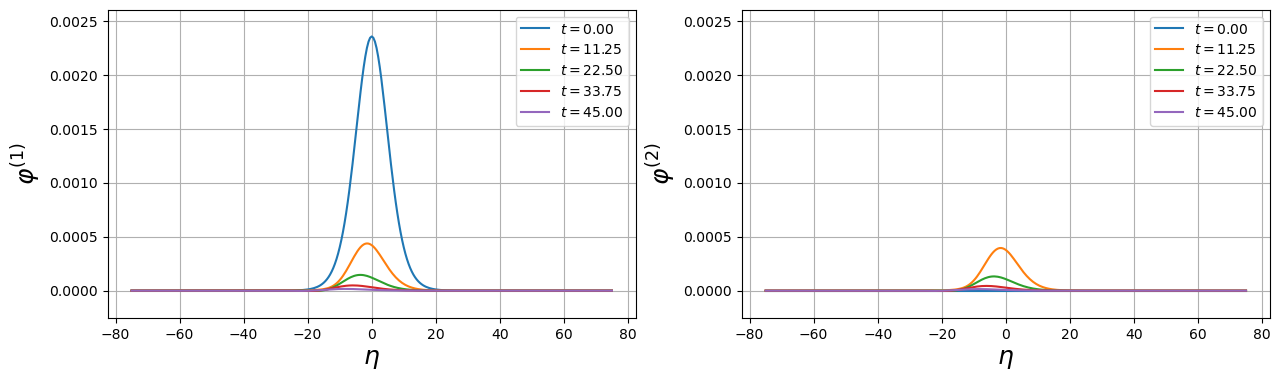

In [35]:
draw(sol1, sol2)
draw(sol1, sol2, "./KDV2-Schamel13.png")

In [36]:
k = 0.2
f2, f32 = 3., 4.
# 2в) все сигмы равны 1(единице) все факторы есть
sig1, sig2, sig3, sig4, sig5 = 0.2, 0.2, 0.4, 0.2, 0.
s1, s2, s3, s4, s5 = 1. + sig5, -1., -sig1 + sig4, sig1, 0.
r1, r2, r3, r4, r5 = 1. + sig2 + sig5, -1., -sig1 - sig3, sig1, 0.
x = array(linspace(-L*.5, L*.5, N), dtype=float64)
sol1, sol2 = solve(ex3(x, 0., k), ex3(x, 0., k), x[1] - x[0], 45., 4)

3 2 2 2 

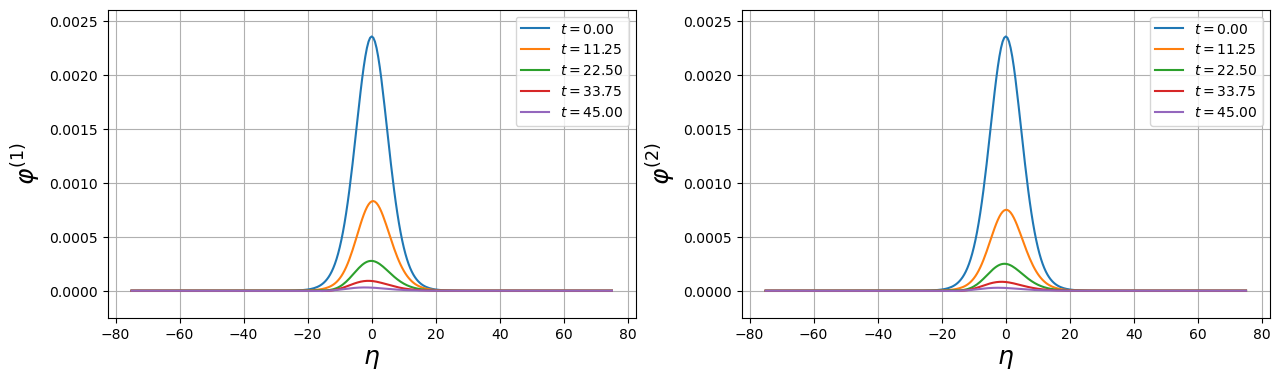

In [37]:
draw(sol1, sol2)
draw(sol1, sol2, "./KDV2-Schamel14.png")

In [38]:
k = 0.2
f2, f32 = 3., 4.
# 2в) все сигмы равны 1(единице) все факторы есть
sig1, sig2, sig3, sig4, sig5 = 0.2, 0.2, 0.4, 0.2, 0.
s1, s2, s3, s4, s5 = 1. + sig5, -1., -sig1 + sig4, sig1, 0.
r1, r2, r3, r4, r5 = 1. + sig2 + sig5, -1., -sig1 - sig3, sig1, 0.
x = array(linspace(-L*.5, L*.5, N), dtype=float64)
sol1, sol2 = solve(ex3(x, 0., k), 0.*ex3(x, 0., k), x[1] - x[0], 45., 4)

2 2 2 2 

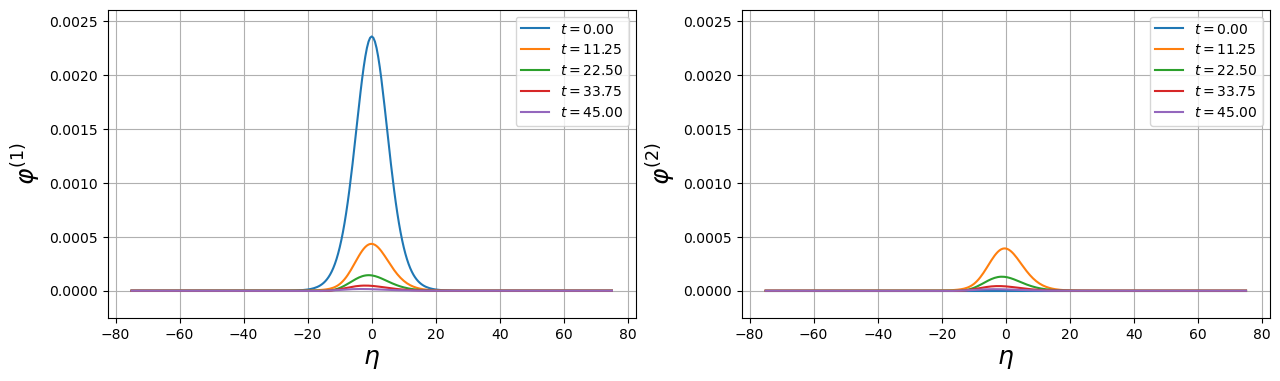

In [39]:
draw(sol1, sol2)
draw(sol1, sol2, "./KDV2-Schamel15.png")

In [40]:
k = 0.2
f32 = 4.
# 2г) все сигмы равны 1(единице) + сигмы5=1 все факторы есть
sig1, sig2, sig3, sig4, sig5 = 0.2, 0.2, 0.4, 0.2, 0.2
s1, s2, s3, s4, s5 = 1. + sig5, -1., -sig1 + sig4, sig1, 0.
r1, r2, r3, r4, r5 = 1. + sig2 + sig5, -1., -sig1 - sig3, sig1, 0.
x = array(linspace(-L*.5, L*.5, N), dtype=float64)
sol1, sol2 = solve(ex3(x, 0., k), ex3(x, 0., k), x[1] - x[0], 15., 4)

3 3 2 2 

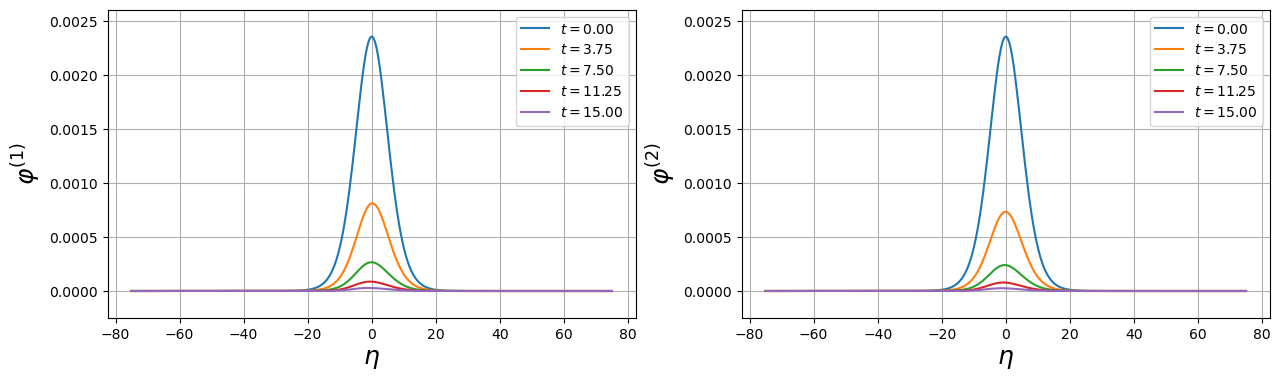

In [41]:
draw(sol1, sol2)
draw(sol1, sol2, "./KDV2-Schamel16.png")

In [42]:
k = 0.2
f2, f32 = 3., 4.
# 2г) все сигмы равны 1(единице) + сигмы5=1 все факторы есть
sig1, sig2, sig3, sig4, sig5 = 0.2, 0.2, 0.4, 0.2, 0.2
s1, s2, s3, s4, s5 = 1. + sig5, -1., -sig1 + sig4, sig1, 0.
r1, r2, r3, r4, r5 = 1. + sig2 + sig5, -1., -sig1 - sig3, sig1, 0.
x = array(linspace(-L*.5, L*.5, N), dtype=float64)
sol1, sol2 = solve(ex3(x, 0., k), 0.*ex3(x, 0., k), x[1] - x[0], 15., 4)

3 3 2 2 

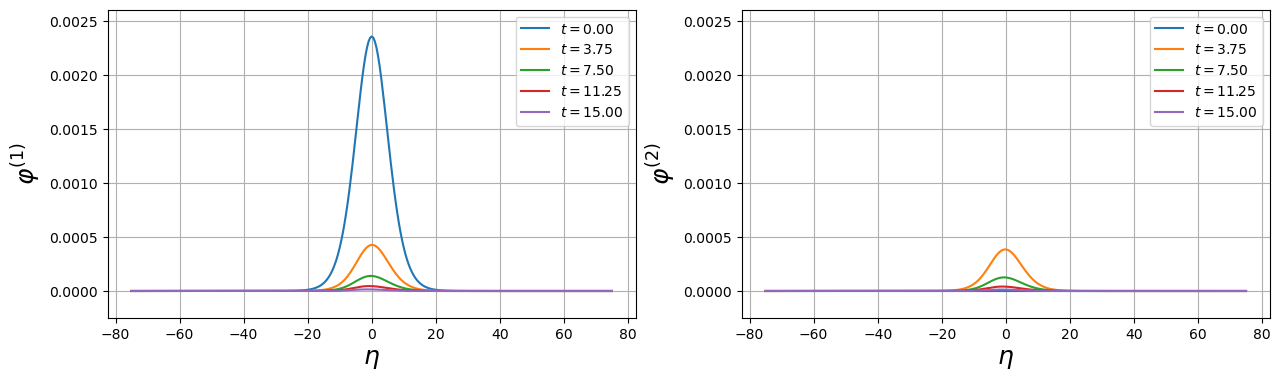

In [43]:
draw(sol1, sol2)
draw(sol1, sol2, "./KDV2-Schamel17.png")

In [29]:
def err(a, b):
    return max(abs(a-b)/(1. + abs(b)))

In [30]:
# размер расчетной области 0 <= x <= L и число точек на ней
L, Ns = 250., [501, 1001, 2001, 4001]
res = []
for N in Ns[:]:
    k = 0.2
    f2, f32 = 3., 4.
    # 1а) сигма1 равна 1 (единица), сигма2,3,4.равны 0(нулю):нет жидкости во внутренней оболочке 
    sig1, sig2, sig3, sig4, sig5 = 0.2, 0., 0., 0., 0.
    s1, s2, s3, s4, s5 = 1. + sig5, -1., -sig1 + sig4, sig1, 0.
    r1, r2, r3, r4, r5 = 1. + sig2 + sig5, -1., -sig1 - sig3, sig1, 0.
    x = array(linspace(-L*.3, L*.7, N), dtype=float64)
    sol1, sol2 = solve(ex3(x, 0., k), ex3(x, 0., k), x[1] - x[0], 600., 16)
    res.append((x, sol1, sol2))

3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

In [31]:
for x, s1, s2 in res:
    for t, u in s1:
        print(t, err(u, ex3(x, t, k)))

0.0 0.0
37.5 3.3575014016329034e-06
75.0 5.95932925800295e-06
112.5 7.822107999458024e-06
150.0 9.331730271142246e-06
187.5 1.065401452540621e-05
225.0 1.1914063656198829e-05
262.5 1.3130990262266552e-05
300.0 1.437689883589791e-05
337.5 1.562119364065363e-05
375.0 1.6807712545300456e-05
412.5 1.8029437514589373e-05
450.0 1.928281651034987e-05
487.5 2.049718599925741e-05
525.0 2.17329995998775e-05
562.5 2.2936183307065075e-05
600.0 2.4166613760787272e-05
0.0 0.0
37.5 8.368877092835133e-07
75.0 1.4873240243173661e-06
112.5 1.9539818430363806e-06
150.0 2.3309245321281303e-06
187.5 2.661782084535516e-06
225.0 2.9824208507813325e-06
262.5 3.287630880466148e-06
300.0 3.6062200086370823e-06
337.5 3.909983207373276e-06
375.0 4.213844070459285e-06
412.5 4.509936231312116e-06
450.0 4.816987195086349e-06
487.5 5.130509370418865e-06
525.0 5.43831045700275e-06
562.5 5.735692280633916e-06
600.0 6.068317552243132e-06
0.0 0.0
37.5 2.090681905974121e-07
75.0 3.718061521803122e-07
112.5 4.8814095824836

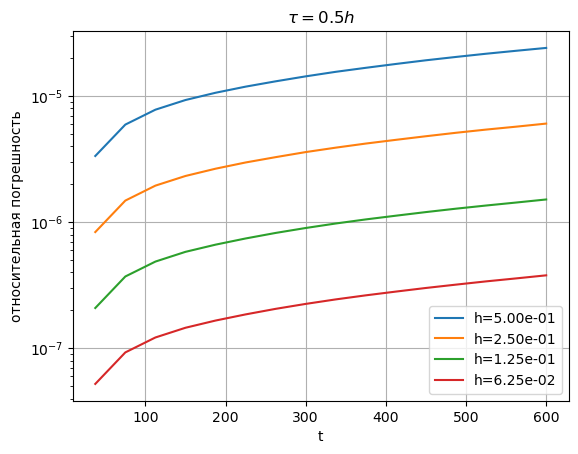

In [34]:
# t = linspace(0., 0.5, 100)
# figure(figsize=(9, 6))
for x, s1, s2 in res:
    X, Y = [], []
    for t, u in s1[1:]:
        X.append(t)
        Y.append(err(u, ex3(x, t, k)))
    plot(X, Y, label="h=%.2e" % (x[1] - x[0]))
# plot(array(X), array(X)**2*1.e-8)
grid()
title(r"$\tau = 0.5 h$")
yscale("log")
legend(loc='best', fancybox=True)
xlabel('t')
ylabel('относительная погрешность')
savefig("error1.png")

In [36]:
L, Ns = 150., [301, 601, 1201, 2401, 4801]
res = []
for N in Ns[:]:
    k = 0.2
    f2, f32 = 3., 4.
    # 2г) все сигмы равны 1(единице) + сигмы5=1 все факторы есть
    sig1, sig2, sig3, sig4, sig5 = 0.2, 0.2, 0.4, 0.2, 0.2
    s1, s2, s3, s4, s5 = 1. + sig5, -1., -sig1 + sig4, sig1, 0.
    r1, r2, r3, r4, r5 = 1. + sig2 + sig5, -1., -sig1 - sig3, sig1, 0.
    x = array(linspace(-L*.5, L*.5, N), dtype=float64)
    sol1, sol2 = solve(ex3(x, 0., k), 0.*ex3(x, 0., k), x[1] - x[0], 15., 4)
    res.append((x, sol1, sol2))

3 3 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 

In [37]:
n = 16
for x, s1, s2 in res[:-1]:
    for i in range(4):
        print(s1[i+1][0], err(s1[i+1][1], res[-1][1][i+1][1][::n]))
    n //= 2

3.75 3.8170830763005164e-07
7.5 2.1088162654047607e-07
11.25 9.555532958700459e-08
15.0 3.8207056461206426e-08
3.75 9.57523805388847e-08
7.5 5.2345137024415166e-08
11.25 2.3664374167484893e-08
15.0 9.45909270046025e-09
3.75 2.2938056423108715e-08
7.5 1.2502345906130104e-08
11.25 5.644925135238496e-09
15.0 2.2545028531323528e-09
3.75 4.602726263060988e-09
7.5 2.504953222676915e-09
11.25 1.1304099901582409e-09
15.0 4.513278949287134e-10


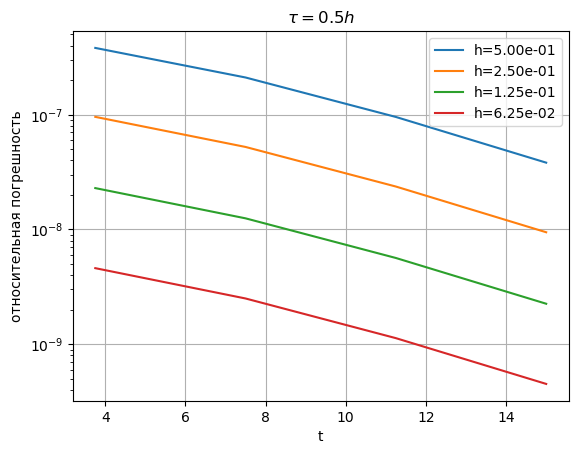

In [38]:
# t = linspace(0., 0.5, 100)
# figure(figsize=(9, 6))
n = 16
for x, s1, s2 in res[:-1]:
    X, Y = [], []
    for i in range(4):
        X.append(s1[i+1][0])
        Y.append(err(s1[i+1][1], res[-1][1][i+1][1][::n]))
    n //= 2
    plot(X, Y, label="h=%.2e" % (x[1] - x[0]))
# plot(array(X), array(X)**2*1.e-8)
grid()
title(r"$\tau = 0.5 h$")
yscale("log")
legend(loc='best', fancybox=True)
xlabel('t')
ylabel('относительная погрешность')
savefig("error2.png")